Análise do dia 18/03 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Criando stopwords em português utilizando a biblioteca nltk

nlp = spacy.load("pt_core_news_sm")
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior', 
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'jairbolsonaro', 'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'fudeu', 'fuder', 'fodeu', 'foda', 'obg',
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda', 'ir', 'vir', 'bem', 'sair', 'tao']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

# Preparação dos dados

In [3]:
# import dos dados

df = pd.read_csv('0318_preprocessado.csv')

In [4]:
# import dos tokens

df_tokens = pd.read_csv('tokens_unicos_10k.csv')

In [5]:
# criação de lista de tokens

lista_token = []

for row in range(0, len(df_tokens)):
    lista_token.append(df_tokens.iloc[row,1])
    
lista_token = set(lista_token)

In [6]:
# filtranso os tokens para aparecer apenas os 10 mil mais frequentes

df['token2'] = df.token.apply(lambda x: str(list(set(literal_eval(x)).intersection(lista_token))))

In [7]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [8]:
# aplica função em todos os tokens

df['token2'] = df['token2'].apply(lambda x: strip_characters(x))
df['token2'] = df['token2'].apply(lambda x: str(x).split(' '))

In [9]:
# transforma os tokens em lista

lista = list(df['token2'])

In [10]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(lista, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[lista], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# função para preprocessar palavras

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts1 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts2 = [bigram_mod[doc] for doc in texts1]
    texts3 = [trigram_mod[bigram_mod[doc]] for doc in texts2]
    texts4 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts3]    
    return texts4

In [12]:
# Processing the abstract

texto = process_words(lista)

# Modelagem

In [13]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [14]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [15]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [08:15<00:00, 35.37s/it]


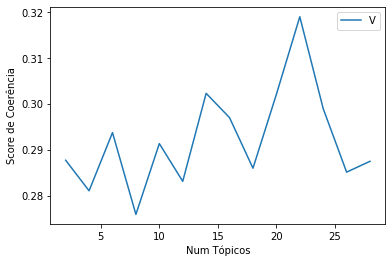

In [17]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [18]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.2877
A quantidade de tópicos = 4  tem um valor de coerência de  0.281
A quantidade de tópicos = 6  tem um valor de coerência de  0.2937
A quantidade de tópicos = 8  tem um valor de coerência de  0.2759
A quantidade de tópicos = 10  tem um valor de coerência de  0.2913
A quantidade de tópicos = 12  tem um valor de coerência de  0.2831
A quantidade de tópicos = 14  tem um valor de coerência de  0.3023
A quantidade de tópicos = 16  tem um valor de coerência de  0.297
A quantidade de tópicos = 18  tem um valor de coerência de  0.286
A quantidade de tópicos = 20  tem um valor de coerência de  0.3021
A quantidade de tópicos = 22  tem um valor de coerência de  0.3191
A quantidade de tópicos = 24  tem um valor de coerência de  0.299
A quantidade de tópicos = 26  tem um valor de coerência de  0.2851
A quantidade de tópicos = 28  tem um valor de coerência de  0.2875


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [19]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=4, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True)

In [20]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -6.734945877566817


In [21]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=lista, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.3148498302893776


In [22]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.040409 -0.354160       1        1  28.944038
0      0.001841  0.032251       2        1  27.146610
1     -0.343276  0.128280       3        1  22.039528
3      0.301026  0.193629       4        1  21.869827, topic_info=            Term          Freq         Total Category  logprob  loglift
18        corona  26843.000000  26843.000000  Default  30.0000  30.0000
3      bolsonaro  24207.000000  24207.000000  Default  29.0000  29.0000
5    coronavirus  15378.000000  15378.000000  Default  28.0000  28.0000
19         virus  12299.000000  12299.000000  Default  27.0000  27.0000
16    presidente  16220.000000  16220.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
51       governo   1211.929443   2446.989746   Topic4  -4.6893   0.8174
16    presidente   1952.660889  16220.626953   Topic4  -4.2124  -0.5970
333       alguem    746.717957   1745.133545   Topic4  -5.1736   0.6712
31         agora    820.088745   5782.822266   Topic4  -5.0799  -0.4332
191        ainda    763.102783   3011.406738   Topic4  -5.1519   0.1473

[199 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
111       2  0.999477    acabar
31        1  0.391677     agora
31        2  0.223939     agora
31        3  0.242442     agora
31        4  0.141799     agora
...     ...       ...       ...
199       3  0.997635   verdade
61        1  0.999270  vergonha
136       2  0.999664      vida
19        3  0.999914     virus
315       3  0.999394    voltar

[199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])

In [23]:
# Escolhe o modelo

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.213*"bolsonaro" + 0.096*"panelaco" + 0.074*"contra" + 0.014*"favor" + '
  '0.012*"agora" + 0.012*"mae" + 0.009*"bairro" + 0.009*"presidente" + '
  '0.008*"lula" + 0.008*"panela"'),
 (1,
  '0.077*"coronavirus" + 0.062*"pandemia" + 0.016*"tempo" + 0.014*"meio" + '
  '0.012*"casa" + 0.012*"brasil" + 0.011*"coisa" + 0.011*"gente" + '
  '0.009*"familia" + 0.009*"mundo"'),
 (2,
  '0.071*"coronavirus" + 0.025*"deus" + 0.021*"casa" + 0.017*"bolsonaro" + '
  '0.015*"fav" + 0.015*"galera" + 0.013*"corona" + 0.013*"cabelo" + '
  '0.013*"tbm" + 0.011*"mundo"'),
 (3,
  '0.108*"bolsonaro" + 0.061*"panela" + 0.030*"povo" + 0.027*"contra" + '
  '0.020*"presidente" + 0.019*"agora" + 0.017*"bater" + 0.017*"depois" + '
  '0.015*"mim" + 0.014*"janela"'),
 (4,
  '0.247*"corona" + 0.117*"virus" + 0.025*"casa" + 0.019*"pegar" + '
  '0.014*"mundo" + 0.013*"agora" + 0.010*"morrer" + 0.010*"medo" + '
  '0.010*"coronavirus" + 0.009*"muito"'),
 (5,
  '0.070*"bolsonaro" + 0.044*"cu" + 0.040*"tomar" + 0.0

In [24]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lista):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [25]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=lista)

In [26]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [27]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9308,"bolsonaro, panelaco, contra, favor, agora, mae...","[tao, boca, lula, azedar, rapaz, nem, panelaco..."
1,1.0,0.9357,"coronavirus, pandemia, tempo, meio, casa, bras...","[morrer, economia, fome, saude, tanto, pois, e..."
2,2.0,0.9400,"coronavirus, deus, casa, bolsonaro, fav, galer...","[gosto, te, tu, saudade, bike, brincadeira, te..."
3,3.0,0.9475,"bolsonaro, panela, povo, contra, presidente, a...","[forte, comecou, edicao, sardinha, maior, pt, ..."
4,4.0,0.9357,"corona, virus, casa, pegar, mundo, agora, morr...","[estar, tambem, meu, unica, cidade, pessoa, co..."
5,5.0,0.9307,"bolsonaro, cu, tomar, presidente, favor, brasi...","[tu, cu, vez, governo, milhoes, vcs, pessoa, c..."
6,6.0,0.9400,"coronavirus, presidente, quando, governo, gent...","[importante, risco, outro, governo, cada, pois..."
7,7.0,0.9400,"presidente, assim, vida, terceiro, ainda, bras...","[ter, sempre, achar, nao, levar, ruim, algo, a..."
8,8.0,0.9307,"casa, ainda, bolsonaro, primeiro, nunca, comig...","[voto, tarde, besteira, haddad, meu, votar, ci..."
9,9.0,0.9250,"coronga, corona, bolsonaro, gente, virus, oq, ...","[tu, tv, haddad, mt, ue, meu, idiota, brigar, ..."


In [28]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,8.0,"casa, ainda, bolsonaro, primeiro, nunca, comig...",26175.0,0.1851
1.0,5.0,"bolsonaro, cu, tomar, presidente, favor, brasi...",15752.0,0.1114
2.0,1.0,"coronavirus, pandemia, tempo, meio, casa, bras...",11443.0,0.0809
3.0,3.0,"bolsonaro, panela, povo, contra, presidente, a...",13743.0,0.0972
4.0,6.0,"coronavirus, presidente, quando, governo, gent...",21539.0,0.1523
...,...,...,...,...
141441.0,1.0,"coronavirus, pandemia, tempo, meio, casa, bras...",NaN,NaN
141442.0,5.0,"bolsonaro, cu, tomar, presidente, favor, brasi...",NaN,NaN
141443.0,8.0,"casa, ainda, bolsonaro, primeiro, nunca, comig...",NaN,NaN
141444.0,4.0,"corona, virus, casa, pegar, mundo, agora, morr...",NaN,NaN


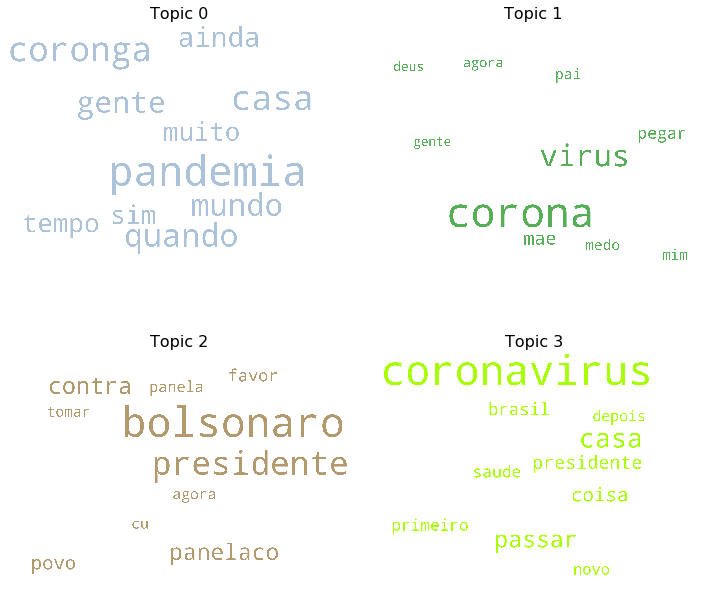

In [29]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()